# Membership Inference using MERLIN and MORGAN

## Setup

In [14]:
import matplotlib.pyplot as plt
import torch

from torchvision import datasets, transforms
from typing import Literal

from config import MODELS, NUM_CLASSES
from privacy_and_grokking.path_keeper import get_path_keeper
from privacy_and_grokking.utils import get_device

In [15]:
pk = get_path_keeper()
device = get_device()

In [16]:
SAMPLE_SIZE = 1_000
BATCH_SIZE = 64
ALLOWED_FALSE_POSITIVE_RATE = 0.05
# As from the paper:
NOISY_SAMPLES = 100
NOISE_SCALE = 0.01

## Data

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # MNIST mean/std
])

train = datasets.MNIST(
    root=pk.CACHE,
    train=True, 
    transform=transform,
    download=True
)
test = datasets.MNIST(
    root=pk.CACHE,
    train=False, 
    transform=transform,
    download=True
)

train_subset, _ = torch.utils.data.random_split(train, [SAMPLE_SIZE, len(train) - SAMPLE_SIZE])
test_subset, _ = torch.utils.data.random_split(test, [SAMPLE_SIZE, len(test) - SAMPLE_SIZE])

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

## Attack

In [18]:
@torch.no_grad()
def generate_data(model, data_loader, loss_type: Literal["entropy"] | Literal["mse"] = "entropy"):
    model.eval()
    match loss_type:
        case "entropy":
            criterion = torch.nn.CrossEntropyLoss(reduction="none")
            label_transform = lambda x: x
            loss_transform = lambda x: x
        case "mse":
            criterion = torch.nn.MSELoss(reduction="none")
            label_transform = lambda x: torch.nn.functional.one_hot(x, num_classes=NUM_CLASSES)
            loss_transform = lambda x: x.sum(dim=1)
        case _:
            raise ValueError(f"Unsupported loss_type: {loss_type}")
    
    data = []
    for (imgs, labels) in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        losses = criterion(output, label_transform(labels))

        for img, loss, label in zip(imgs, losses, labels):
            noise = torch.randn((NOISY_SAMPLES, *img.shape), device=device) * NOISE_SCALE
            noisy_imgs = img.unsqueeze(0) + noise
            noisy_output = model(noisy_imgs)
            noisy_losses = criterion(noisy_output, label_transform(label.repeat(NOISY_SAMPLES)))
            data.append((loss_transform(loss.unsqueeze(0)).squeeze(0).cpu(), loss_transform(noisy_losses).cpu(), label.cpu()))
    return data

def procedure_5_1(data, allowed_fpr):
    data.sort(descending=True)
    allowed_false_positives = int(len(data) * allowed_fpr)
    if allowed_false_positives == 0:
        threshold = data[0] + 0.0001 
    else:
        threshold = data[allowed_false_positives]
    return threshold

def find_merlin_threshold(nonmember_votes, allowed_fpr):
    # Find best Merlin threshold based on allowed false positive rate.
    # Usually, one would use a shadow model for this.
    return procedure_5_1(nonmember_votes, allowed_fpr)

def find_morgan_upper_threshold(nonmember_losses, allowed_fpr):
    upper_threshold = procedure_5_1(nonmember_losses, allowed_fpr)
    return upper_threshold


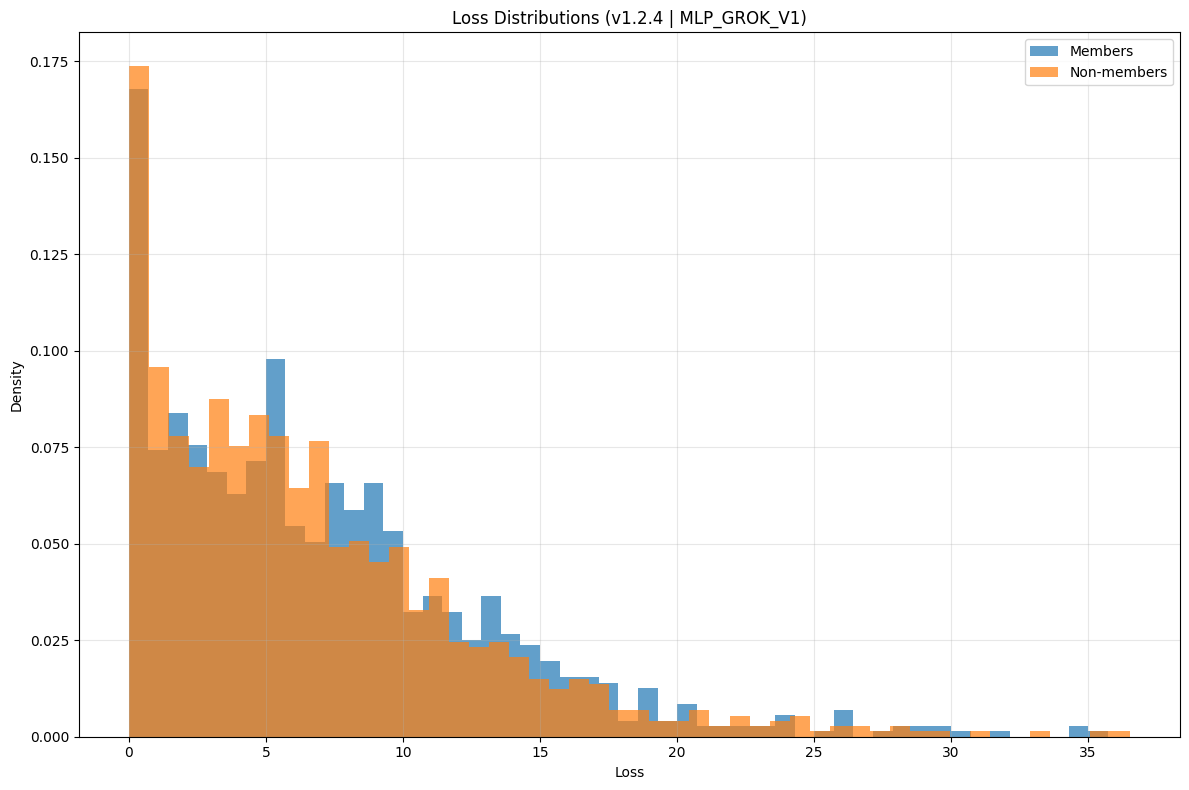

RUN: v1.2.4, Model: MLP_GROK_V1, Step: 5000
	Merlin Threshold: 0.5299999713897705
	False Positive Rate: 30.00 % (allowed: 5.00 %)
	True Positive Rate: 28.70 %
	Morgan Upper Threshold: 11.195961952209473
	Morgan Lower Threshold: 0
	Morgan False Positive Rate: 25.50 % (allowed: 5.00 %)
	Morgan True Positive Rate: 23.50 %


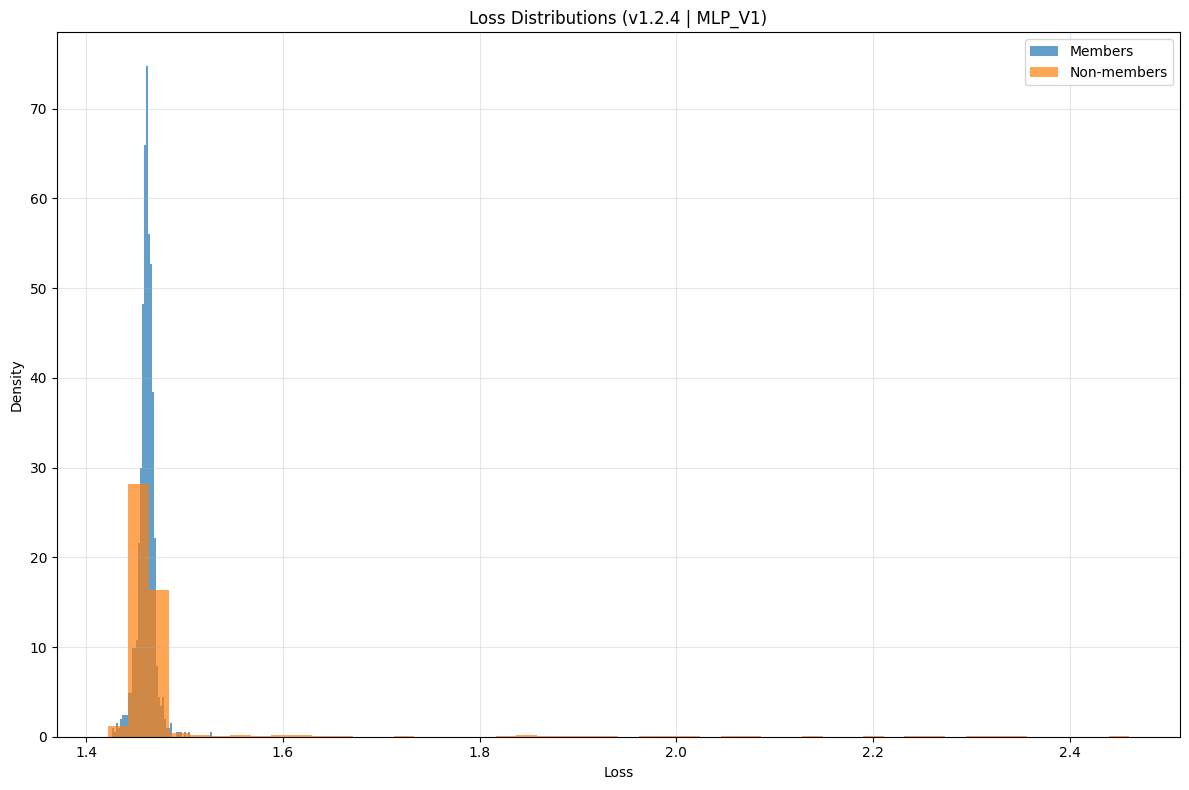

RUN: v1.2.4, Model: MLP_V1, Step: 100000
	Merlin Threshold: 0.5600000023841858
	False Positive Rate: 9.50 % (allowed: 5.00 %)
	True Positive Rate: 8.90 %
	Morgan Upper Threshold: 1.4496519565582275
	Morgan Lower Threshold: 0
	Morgan False Positive Rate: 1.10 % (allowed: 5.00 %)
	Morgan True Positive Rate: 0.80 %


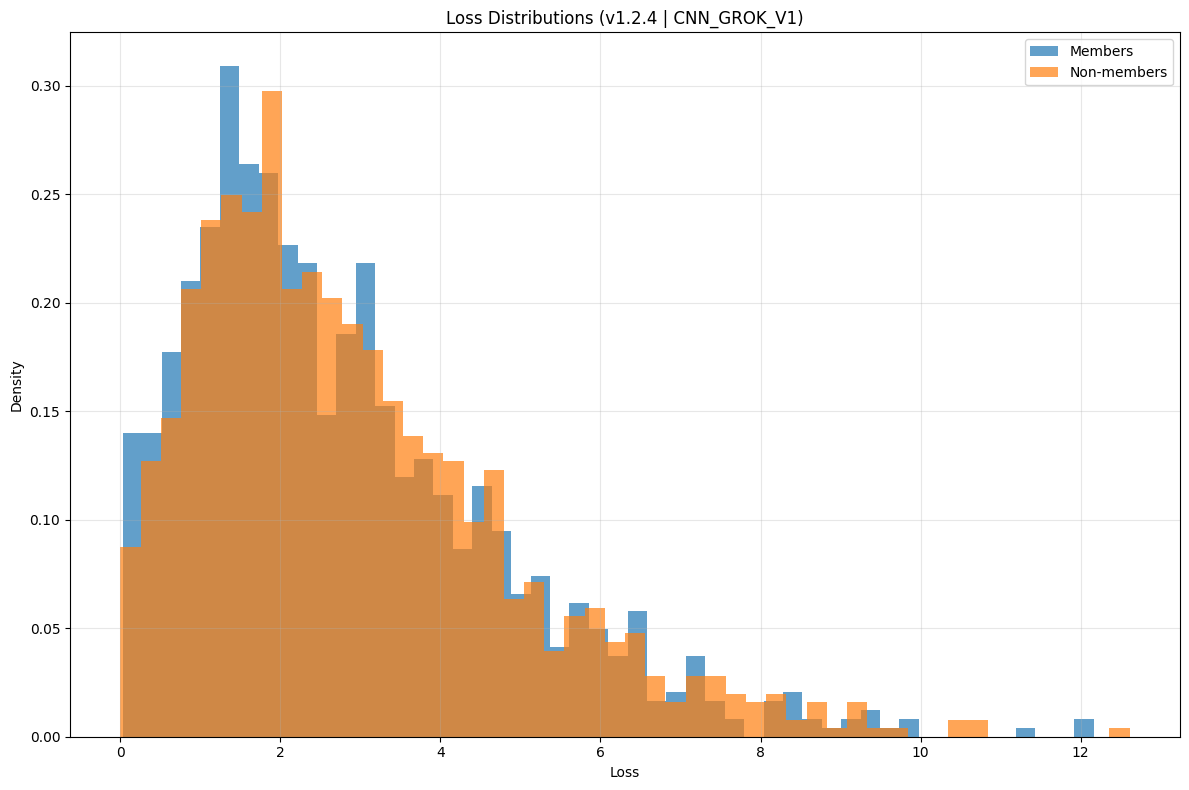

RUN: v1.2.4, Model: CNN_GROK_V1, Step: 30000
	Merlin Threshold: 0.5299999713897705
	False Positive Rate: 46.90 % (allowed: 5.00 %)
	True Positive Rate: 48.40 %
	Morgan Upper Threshold: 3.0125417709350586
	Morgan Lower Threshold: 0
	Morgan False Positive Rate: 31.50 % (allowed: 5.00 %)
	Morgan True Positive Rate: 32.50 %


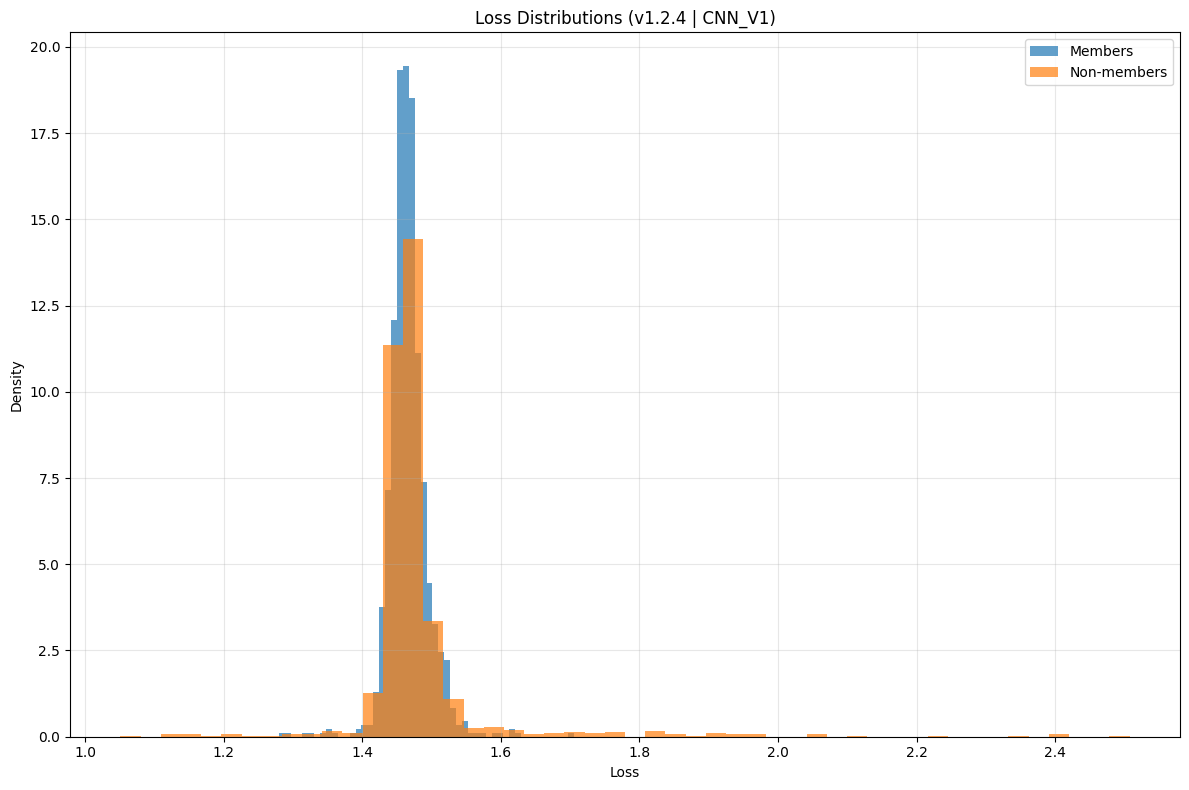

RUN: v1.2.4, Model: CNN_V1, Step: 100000
	Merlin Threshold: 0.23999999463558197
	False Positive Rate: 17.90 % (allowed: 5.00 %)
	True Positive Rate: 17.10 %
	Morgan Upper Threshold: 1.4115647077560425
	Morgan Lower Threshold: 0
	Morgan False Positive Rate: 2.30 % (allowed: 5.00 %)
	Morgan True Positive Rate: 1.10 %


In [19]:
for config in MODELS:
    update = config.updates[1] if len(config.updates) > 2 else config.updates[-1]
    pk.set_params({"run_id": config.id, "model": config.name, "step": update})

    model = config.model_class()
    model.load_state_dict(torch.load(pk.MODEL_TORCH, weights_only=True, map_location=device))
    model.to(device)

    LOSS_TYPE = ["entropy", "mse"][0]
    train = generate_data(model, train_loader, loss_type=LOSS_TYPE)
    test = generate_data(model, test_loader, loss_type=LOSS_TYPE)
    train_votes = torch.tensor([(noisy_losses > loss).sum() / NOISY_SAMPLES for (loss, noisy_losses, label) in train])
    test_votes = torch.tensor([(noisy_losses > loss).sum() / NOISY_SAMPLES for (loss, noisy_losses, label) in test])

    merlin_threshold = find_merlin_threshold(test_votes, ALLOWED_FALSE_POSITIVE_RATE)
    merlin_actual_fpr = (test_votes > merlin_threshold).sum() / len(test_votes)
    merlin_actual_tpr = (train_votes > merlin_threshold).sum() / len(train_votes)

    train_losses = torch.tensor([loss for (loss, _, _) in train]) 
    test_losses = torch.tensor([loss for (loss, _, _) in test])
    morgan_upper_threshold = find_morgan_upper_threshold(test_losses, ALLOWED_FALSE_POSITIVE_RATE)
    morgan_lower_threshold = 0
    # Find best Morgan lower threshold based on allowed false positive rate.
    # Grid search:
    # for lower_threshold in torch.linspace(test_losses.min(), morgan_upper_threshold.item(), steps=100):
    #     morgan_vote = lambda noisy_losses, loss: (lower_threshold < loss < morgan_upper_threshold) and ((noisy_losses > loss).sum() / NOISY_SAMPLES) > merlin_threshold
    #     morgan_actual_fpr = torch.tensor([morgan_vote(noisy_losses, loss) for (loss, noisy_losses, _) in test]).sum() / len(test)
    #     morgan_actual_tpr = torch.tensor([morgan_vote(noisy_losses, loss) for (loss, noisy_losses, _) in train]).sum() / len(train)
    #     print(lower_threshold, morgan_actual_fpr, morgan_actual_tpr)
    morgan_vote = lambda noisy_losses, loss: (morgan_lower_threshold < loss < morgan_upper_threshold) and ((noisy_losses > loss).sum() / NOISY_SAMPLES) > merlin_threshold
    morgan_actual_fpr = torch.tensor([morgan_vote(noisy_losses, loss) for (loss, noisy_losses, _) in test]).sum() / len(test)
    morgan_actual_tpr = torch.tensor([morgan_vote(noisy_losses, loss) for (loss, noisy_losses, _) in train]).sum() / len(train)

    plt.figure(figsize=(12, 8))  
    plt.hist(train_losses.numpy(), bins=50, alpha=0.7, label="Members", density=True)
    plt.hist(test_losses.numpy(), bins=50, alpha=0.7, label="Non-members", density=True)
    plt.xlabel("Loss")
    plt.ylabel("Density")
    plt.title("Loss Distributions ({} | {})".format(config.id, config.name))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("RUN: {}, Model: {}, Step: {}".format(config.id, config.name, update))
    # print("RUN: {}, Model: {}, Step: {}".format(config.id, config.name, update))
    print("\tMerlin Threshold:", merlin_threshold.item())
    print("\tFalse Positive Rate: {:.2f} % (allowed: {:.2f} %)".format(merlin_actual_fpr.item() * 100, ALLOWED_FALSE_POSITIVE_RATE * 100))
    print("\tTrue Positive Rate: {:.2f} %".format(merlin_actual_tpr.item() * 100))
    print("\tMorgan Upper Threshold:", morgan_upper_threshold.item())
    print("\tMorgan Lower Threshold:", morgan_lower_threshold)
    print("\tMorgan False Positive Rate: {:.2f} % (allowed: {:.2f} %)".format(morgan_actual_fpr.item() * 100, ALLOWED_FALSE_POSITIVE_RATE * 100))
    print("\tMorgan True Positive Rate: {:.2f} %".format(morgan_actual_tpr.item() * 100))